In [1]:
device = 'cuda'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
data = np.load('dataset/terrain_dataset.npy').astype(np.float32)

data -= np.mean(data)
data /= np.std(data)

data = torch.from_numpy(data).float()
data = data.view(-1, 1, 64, 64)
dataset = torch.utils.data.TensorDataset(data)
train, test = torch.utils.data.random_split(dataset, [0.9, 0.1])
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)
print(data.shape)


torch.Size([65349, 1, 64, 64])


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [5]:
class Generator(nn.Module):
    def __init__(self, nz, nf):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, nf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.ReLU(True),

            # state size. (nf * 16) x 4 x 4
            nn.ConvTranspose2d(nf * 8, nf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.ReLU(True),

            # state size. (nf * 8) x 8 x 8
            nn.ConvTranspose2d(nf * 4, nf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.ReLU(True),

            # state size. (nf * 4) x 16 x 16
            nn.ConvTranspose2d(nf * 2, nf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nf),
            nn.ReLU(True),

            # state size. (nf * 2) x 32 x 32
            nn.ConvTranspose2d(nf, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),

            # state size. (1) x 64 x 64
        )
    
    def forward(self, input):
        return self.model(input)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, nf):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(1, nf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (nf) x 32 x 32
            nn.Conv2d(nf, nf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (nf * 2) x 16 x 16
            nn.Conv2d(nf * 2, nf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (nf * 4) x 8 x 8
            nn.Conv2d(nf * 4, nf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (nf * 8) x 4 x 4
            nn.Conv2d(nf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.model(input)

In [7]:
net_discriminator = Discriminator(64).to(device)
net_discriminator.apply(weights_init)
net_generator = Generator(100, 64).to(device)
net_generator.apply(weights_init)

net_discriminator

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [8]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0

optimizerD = torch.optim.Adam(net_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(net_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
for epoch in range(10):
    for i, data in enumerate(train_loader):
        ##############
        # Training D #
        ##############
        net_discriminator.zero_grad()

        # Train on real images
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        output = net_discriminator(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        D_x = output.mean().item()

        # Train on fake images
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake = net_generator(noise)
        label.fill_(fake_label)
        output = net_discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()

        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake

        optimizerD.step()

        ##############
        # Training G #
        ##############
        net_generator.zero_grad()
        label.fill_(real_label)
        output = net_discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()

        D_G_z2 = output.mean().item()

        optimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch}][{i}/{len(train_loader)}]\t'
                  f'D Loss: {errD.item():.4f}\t'
                  f'G Loss: {errG.item():.4f}\t'
                  f'D(x): {D_x:.4f}\t'
                  f'D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
        

[0][0/919]	D Loss: 1.8980	G Loss: 6.3188	D(x): 0.7327	D(G(z)): 0.7353 / 0.0030
[0][50/919]	D Loss: 0.0045	G Loss: 19.9770	D(x): 0.9955	D(G(z)): 0.0000 / 0.0000
[0][100/919]	D Loss: 0.0329	G Loss: 10.6793	D(x): 0.9953	D(G(z)): 0.0277 / 0.0000
[0][150/919]	D Loss: 0.0052	G Loss: 7.5546	D(x): 0.9980	D(G(z)): 0.0032 / 0.0006
[0][200/919]	D Loss: 0.0027	G Loss: 7.5004	D(x): 0.9988	D(G(z)): 0.0015 / 0.0006
[0][250/919]	D Loss: 0.0025	G Loss: 7.5540	D(x): 0.9994	D(G(z)): 0.0018 / 0.0006
[0][300/919]	D Loss: 0.0013	G Loss: 46.1720	D(x): 0.9987	D(G(z)): 0.0000 / 0.0000
[0][350/919]	D Loss: 0.0002	G Loss: 46.1423	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0][400/919]	D Loss: 0.0003	G Loss: 46.0720	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0][450/919]	D Loss: 0.0002	G Loss: 45.9023	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0][500/919]	D Loss: 0.0002	G Loss: 45.9283	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0][550/919]	D Loss: 0.0001	G Loss: 45.9010	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0][600/919]	D Loss: 0.

KeyboardInterrupt: 

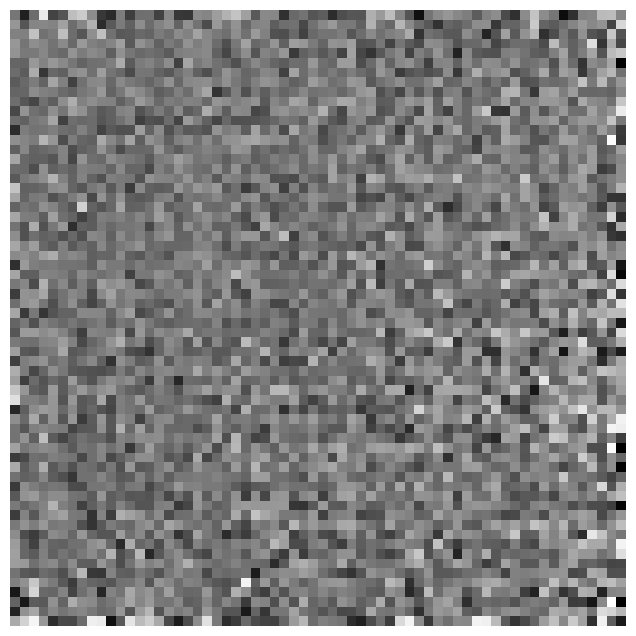

In [ ]:
fig = plt.figure(figsize=(8, 8))
with torch.no_grad():
    fake = net_generator(fixed_noise).detach().cpu()
    plt.imshow(fake[0, 0], cmap='gray')
    plt.axis('off')